In [4]:
import pandas as pd
import nltk
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
def clean_text(text):
    # Tokenize and remove punctuation
    tokens = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stopwords.words('english') and word.isalpha()]
    return tokens

In [69]:
base_dir = os.getcwd()  # Get the script's directory
output_dir = os.path.join(base_dir, "..", "..", "output")

file_path1 = os.path.join(output_dir, "auto_labeled_data.xlsx")
df1 = pd.read_excel(file_path1)

In [70]:
df1['tokens_cleaned'] = df1['Combined_text'].apply(clean_text)

In [71]:
# Combine all the text into one list of tokens for collocation analysis
all_tokens = [token for tokens in df1['tokens_cleaned'] for token in tokens]

# Find bigrams (pairs of words) and trigrams (triplets of words)
bigram_finder = BigramCollocationFinder.from_words(all_tokens)
trigram_finder = TrigramCollocationFinder.from_words(all_tokens)

In [72]:
# Filter by frequency
bigram_finder.apply_freq_filter(20)  # Consider bigrams that appear at least 5 times
trigram_finder.apply_freq_filter(20)  # Consider trigrams that appear at least 5 times

# Get the top bigrams and trigrams
bigrams = bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 10)  # Top 10 bigrams
trigrams = trigram_finder.nbest(TrigramAssocMeasures.likelihood_ratio, 10)

In [73]:
print("Top 10 Bigrams:")
print(bigrams)
print("\nTop 10 Trigrams:")
print(trigrams)

Top 10 Bigrams:
[('tel', 'aviv'), ('come', 'come'), ('gaza', 'strip'), ('west', 'bank'), ('prime', 'minister'), ('car', 'car'), ('middle', 'east'), ('united', 'states'), ('air', 'force'), ('southern', 'lebanon')]

Top 10 Trigrams:
[('come', 'come', 'come'), ('car', 'car', 'car'), ('northern', 'gaza', 'strip'), ('prime', 'minister', 'netanyahu'), ('strong', 'strong', 'strong'), ('went', 'went', 'went'), ('israeli', 'prime', 'minister'), ('israeli', 'air', 'force'), ('mixture', 'mixture', 'mixture'), ('station', 'station', 'station')]


## Co-Occurence Analysis

In [79]:
# Initialize CountVectorizer with stopwords removal
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))

# Fit and transform the cleaned text to create the co-occurrence matrix
X = vectorizer.fit_transform(df1['Combined_text'])

In [80]:
# Get the terms (words) from the vectorizer
terms = vectorizer.get_feature_names_out()

# Create the co-occurrence matrix by multiplying the matrix by its transpose
co_occurrence_matrix = X.T * X

# Convert the matrix to a DataFrame for easy viewing
co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=terms, columns=terms)

# Optional: Display the most frequent co-occurring words
print(co_occurrence_df.head())

       00  000  000lb  006  00am  00pm  012625  019  02  0230  ...  يقسم  \
00     11    1      0    0     0     0       0    0   0     0  ...     0   
000     1  101      0    0     0     0       0    2   0     1  ...     0   
000lb   0    0      1    0     0     0       0    0   0     0  ...     0   
006     0    0      0    1     0     0       0    0   0     0  ...     0   
00am    0    0      0    0     1     1       0    0   0     0  ...     0   

       پوزیس  پیام  چیز  کتبام  که  یک  んです  ーい  放心  
00         0     0    0      0   0   0    0   0   0  
000        0     0    0      0   0   0    0   0   0  
000lb      0     0    0      0   0   0    0   0   0  
006        0     0    0      0   0   0    0   0   0  
00am       0     0    0      0   0   0    0   0   0  

[5 rows x 9776 columns]


In [83]:
# Visualize the co-occurrence network
# Create a graph object
G = nx.Graph()

# Add nodes (words) to the graph
for term in terms:
    G.add_node(term)

# Add edges (co-occurrences) with weights (frequency of co-occurrence)
for i, term1 in enumerate(terms):
    for j, term2 in enumerate(terms):
        if co_occurrence_df.iloc[i, j] > 0 and term1 != term2:
            G.add_edge(term1, term2, weight=co_occurrence_df.iloc[i, j])

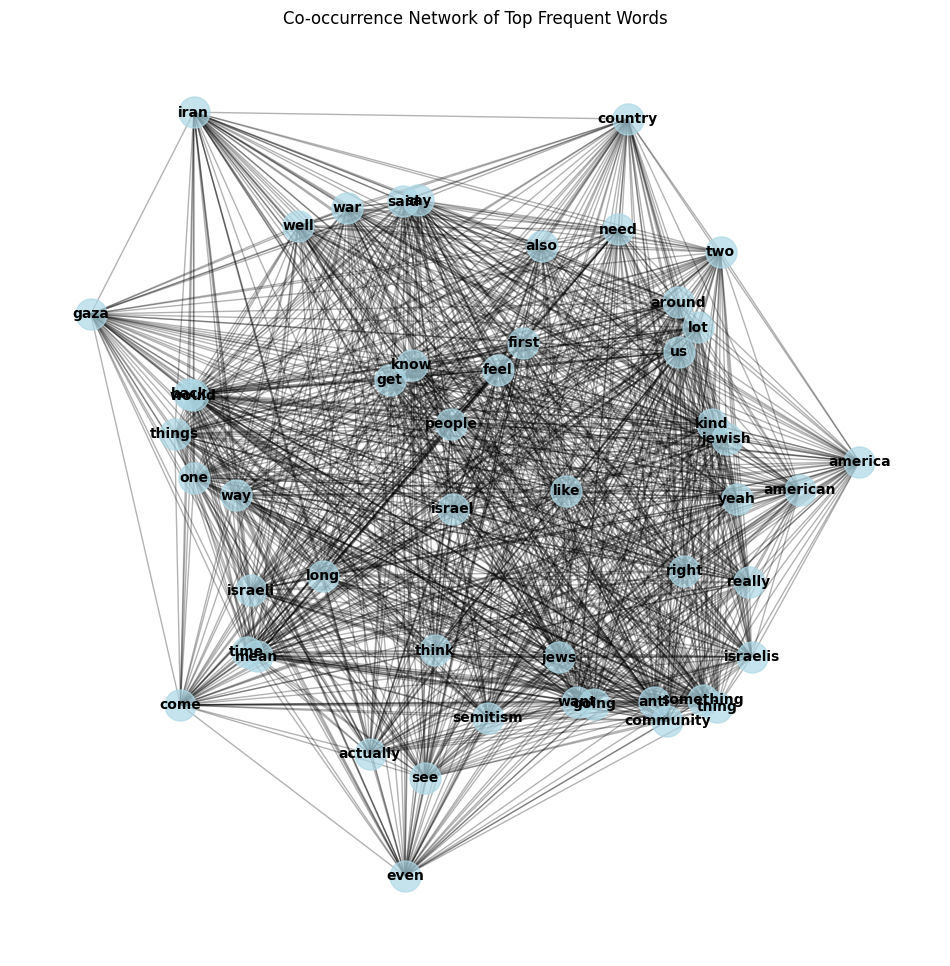

In [93]:
# Select the top N most frequent words
top_n = 50  # Adjust as needed
frequent_terms = co_occurrence_df.sum(axis=1).sort_values(ascending=False).head(top_n).index
filtered_df = co_occurrence_df.loc[frequent_terms, frequent_terms]

# Visualize the co-occurrence network
G = nx.Graph()
for i, term1 in enumerate(frequent_terms):
    for j, term2 in enumerate(frequent_terms):
        if filtered_df.iloc[i, j] > 0 and term1 != term2:
            G.add_edge(term1, term2, weight=filtered_df.iloc[i, j])

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='black')

plt.title("Co-occurrence Network of Top Frequent Words")
plt.axis('off')
plt.savefig(os.path.join(output_dir, "co_occurrence_top_freq_words.png"), dpi=300)
plt.show()

C:\Users\Hp\AppData\Local\Temp\ipykernel_11640\59884852.py:21: UserWarning: Glyph 12435 (\N{HIRAGANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "co_occurrence_threshold.png"), dpi=300)
C:\Users\Hp\AppData\Local\Temp\ipykernel_11640\59884852.py:21: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "co_occurrence_threshold.png"), dpi=300)
C:\Users\Hp\AppData\Local\Temp\ipykernel_11640\59884852.py:21: UserWarning: Glyph 12377 (\N{HIRAGANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "co_occurrence_threshold.png"), dpi=300)
C:\Users\Hp\AppData\Local\Temp\ipykernel_11640\59884852.py:21: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(output_dir, "co_occurrence_threshold.png"), dpi=300)
C:\Users\Hp\AppData\Local\Temp\ipykernel_11640\59884852.py:21: UserWarning: Glyph 245

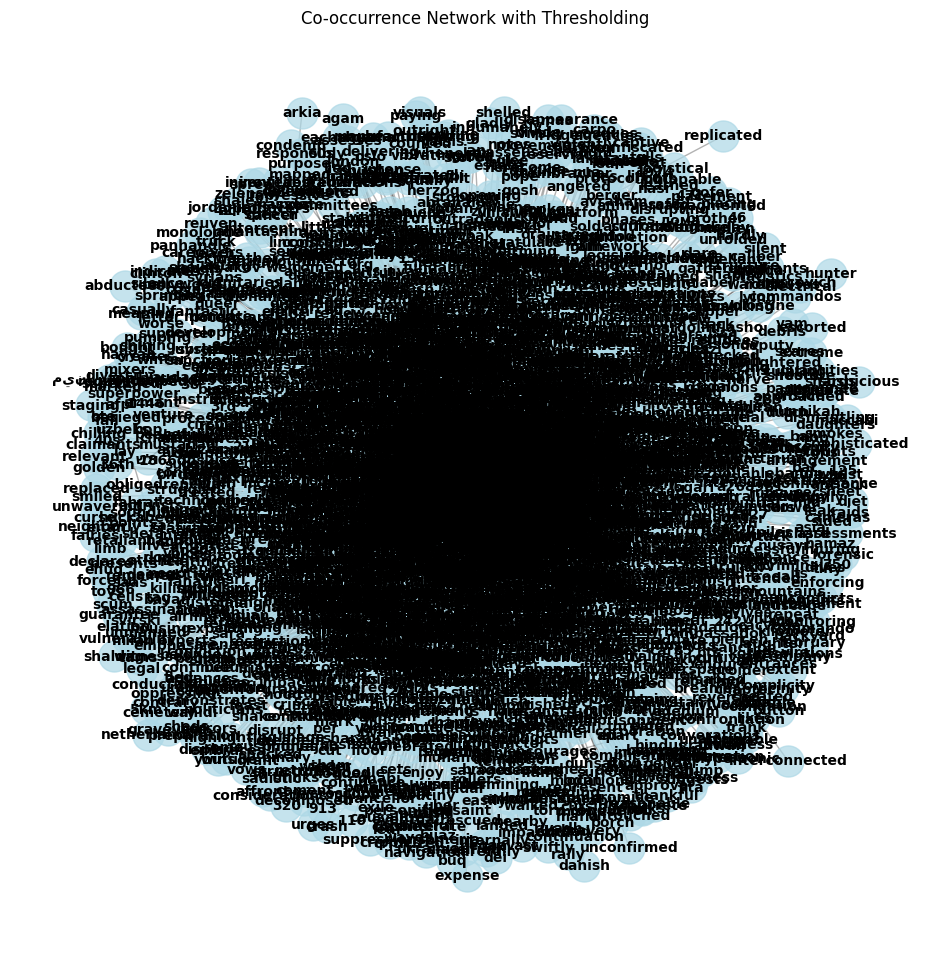

In [94]:
# Apply a threshold to the co-occurrence matrix
threshold = 5  # Adjust this based on the distribution of co-occurrence values
filtered_df = co_occurrence_df[co_occurrence_df > threshold].dropna(axis=0, how='all').dropna(axis=1, how='all')

# Visualize the co-occurrence network
G = nx.Graph()
for i, term1 in enumerate(filtered_df.index):
    for j, term2 in enumerate(filtered_df.columns):
        if filtered_df.iloc[i, j] > 0 and term1 != term2:
            G.add_edge(term1, term2, weight=filtered_df.iloc[i, j])

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='black')

plt.title("Co-occurrence Network with Thresholding")
plt.axis('off')
plt.savefig(os.path.join(output_dir, "co_occurrence_threshold.png"), dpi=300)
plt.show()